# Projet 7 : Détecter les bads buzz grâce au Deep Learning - Air Paradis

- Problématique : Air Paradis a besoin de détecter les mauvais tweet afin de pouvoir agir rapidement.

Il faut ainsi développer un produit IA en utilisant 3 approches : 
- approche “API sur étagère” en utilisant l’API du service cognitif proposé par Microsoft Azure pour l’analyse de sentiment sur un échantillon des données
- approche “Modèle sur mesure simple” en utilisant le Concepteur / Designer d’un service Azure Machine Learning, interface graphique drag & drop, pour développer rapidement un modèle classique (ex : régression logistique) permettant de prédire le sentiment associé à un tweet.
- approche “Modèle sur mesure avancé” en utilisant le service Azure Machine Learning pour développer un modèle basé sur des réseaux de neurones profonds pour prédire le sentiment associé à un tweet qui sera présenté à Air Paradis

Les données utilisées sont des données opensource provenant de ce lien : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip

Import des bibliothèques

In [9]:
import random
import os
# notre package de fonctionnalités
from Package import Scripts_Analyse01 as pk
from Package import Scripts_AnalyseMulti01 as pk_multi
from Package import Scripts_AnalyseMulti02_Unsupervised as pk_multi_unsp
from Package import Scripts_AnalyseMulti02_Supervised as pk_multi_sup
from IPython.core.display import display, HTML
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from umap import UMAP
from scipy.stats import pearsonr
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from yellowbrick.features import ParallelCoordinates
from plotly.graph_objects import Layout
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.features import PCA as PCA_yellow
from yellowbrick.style import set_palette
from sklearn import metrics
from gensim.models.ldamodel import LdaModel
from  sklearn.feature_extraction.text  import CountVectorizer 
from sklearn.decomposition import SparsePCA
import gc
import time
from contextlib import contextmanager
from sklearn import cluster
import warnings
from dotenv import load_dotenv
import re
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from wordcloud import WordCloud
from unidecode import unidecode
from sklearn import metrics
from sklearn import manifold, decomposition
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from nltk.stem.snowball import SnowballStemmer
from spacy.language import Language
import spacy
from spacymoji import Emoji
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
from functools import partial
from gensim.models import FastText  
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext pycodestyle_magic


In [10]:
from tqdm import tqdm,notebook
notebook.tqdm().pandas()

0it [00:00, ?it/s]

In [11]:
load_dotenv()

Python-dotenv could not parse statement starting at line 1


True

## Collecte des données

### Import des données

In [4]:
df = pd.read_csv('input/base.csv', encoding='latin-1', header=None)

In [5]:
df.shape

(1600000, 6)

In [6]:
df.head(2)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


In [7]:
df = df.drop([3], axis=1)

In [9]:
df.head(2)

,0,1,2,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...


In [10]:
df.columns = ["target", "identity", "date", "username", "tweet"]

In [11]:
df.shape

(1600000, 5)

In [12]:
df.head(2)

,target,identity,date,username,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...


#### Nous conservons uniquement les classes positives et négatives 

In [13]:
part1 = df.loc[df["target"]==0]

In [14]:
part1 = part1.sample(800)

In [15]:
part2 = df.loc[df["target"]==4]

In [16]:
part2 = part2.sample(800)

In [17]:
df = pd.concat([part1, part2])

In [18]:
df.shape

(1600, 5)

### Export csv

In [170]:
df.to_csv("output/sample.csv")

In [4]:
df = pd.read_csv("output/sample.csv")

In [5]:
del df["Unnamed: 0"]

## Construction de la base de données

## Pré-traitement des données

Vérification des doublons

In [6]:
sum(df.duplicated())

0

In [7]:
df.head(2)

,target,identity,date,username,tweet
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good"


Vérification des données manquantes

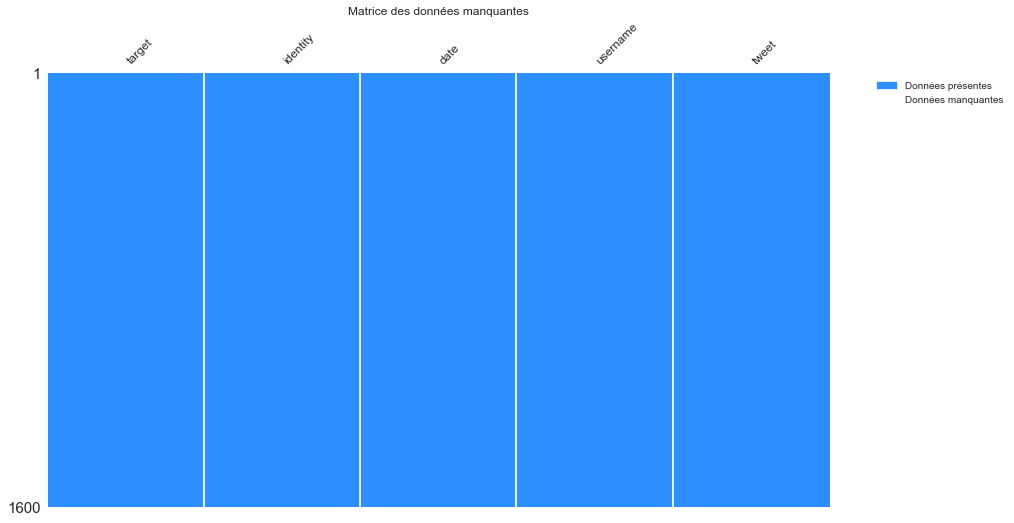

In [12]:
pk.matrix_vm(df, (14,8), (0.18, 0.56, 1))

Aucune donnée manquante

Passons au traitement du texte

In [13]:
df.head(2)

,target,identity,date,username,tweet
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good"


Regardons le nombre de texte en fonction de la variable "TARGET"  qui représente la polarité du tweet (0 = negative, 2 = neutral et 4 = positive)

Avant créons une variable avec les libellées pour améliorer la lisibilité

In [6]:
def lib_polarite_target(target):
    if target == 0:
        return "Negative"
    elif target == 2:
        return "Neutral"
    elif target == 4:
        return "Positive"

df["target_lib"] = df["target"].progress_apply(lambda x: lib_polarite_target(x))

  0%|          | 0/1600 [00:00<?, ?it/s]

In [372]:
df.head(5)

,target,identity,date,username,tweet,target_lib
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative
2,0,2064059763,Sun Jun 07 05:05:10 PDT 2009,ohglorymegan,Emily thought it'd be cool to just take my bla...,Negative
3,0,2217050969,Wed Jun 17 20:19:28 PDT 2009,brojoghost,@BlizzardSkies nothing will ever help Iran. We...,Negative
4,0,2265139701,Sun Jun 21 05:53:13 PDT 2009,itsamishmash,"drunk, and missing one of my best friends wedd...",Negative


Etudions notre variable

In [7]:
def graph_circle(data, column, title):
    """
    Graphique circulaire
    Args:
        data ([type]): données de la colonne à representer
        column ([type]): nom de la colonne
        title ([type]): titre du graphique
    Exemple:
    graph_circle(data["libelle_francais"], "libelle_francais",
                 "Répartition des arbres en fonction de leur appellation")
    """
    t = pd.crosstab(data, "freq", normalize=True)
    t = t.assign(column=t.index, freq=100 * t.freq)
    plt.figure(figsize=(18, 8))
    plt.pie(t.freq, labels=t.column,  autopct='%.0f%%')

    plt.title(title)
    my_circle = plt.Circle((0, 0), 0.4, color='white')
    p = plt.gcf()
    p.gca().add_artist(my_circle)

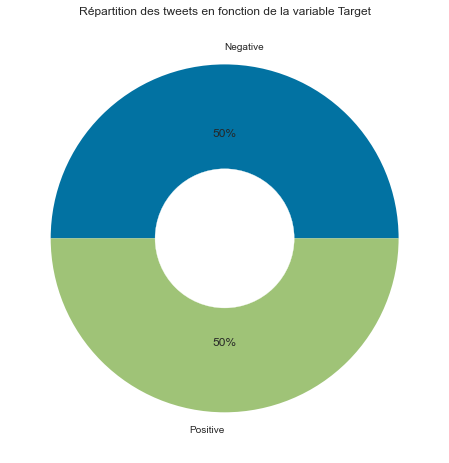

In [374]:
graph_circle(df["target_lib"], "Target",
                 "Répartition des tweets en fonction de la variable Target")

Nous observons que notre variable cible est à peu près équilibrée. En effet, nous retrouvons 57% de tweets avec un sentiment positif, contre 43% avec un sentiment negatif.

Traçons un wordcloud par classe même si le texte n'est pas encore nettoyé

In [8]:
gc.collect()

60

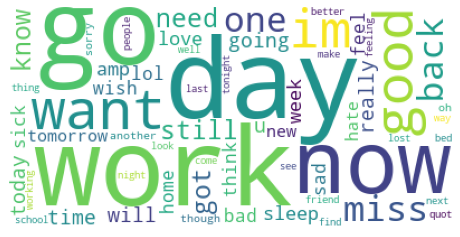

In [376]:
pk.wordcloud_plot(df.loc[df["target"]==0]["tweet"])

Nous avons ici des mots plutôt négatifs avec oh, never, horrible, burnt, byye, sorry, work, go.

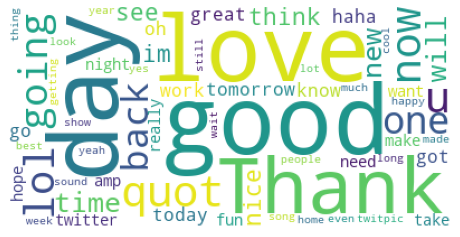

In [377]:
pk.wordcloud_plot(df.loc[df["target"]==4]["tweet"])

Nous retrouvons des mots positifs avec thank, good, well, yeah, love...

### Passons au nettoyage et à l'analyse de la variable "tweet"

In [378]:
df.head(2)

,target,identity,date,username,tweet,target_lib
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,Negative
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",Negative


In [379]:
df["tweet"][0]

"@drallenlubell do know anything about sphincter of oddi dysfunction? If so, can you pls send me a link? Dx'd but unable to do ERCP "

Nous observons que des tweets mélangent majuscule et minuscule. Nous allons donc mettre le texte en minuscule. Notons aussi que nous observons un @. Il faudra donc supprimer la ponctuation.

Pour cela, nous allons utiliser spacy. Et créer un pipeline que nous complèterons au fur et à mesure afin d'avoir un texte nettoyé.
Nous mettrons donc par la suite notre texte en minuscule et nous supprimerons la ponctuation.

Nous savons que dans les tweets, nous pouvons trouver : 
- des emoticônes et des emojicônes
- des mentions (ex : @toto)
- des hashtags (ex #toureiffel)
- des reponses directes à d'autres tweets, qui seront notées avec "RE"
- des emails
- des urls

En conséquence, nous devons retranscrire les emojicônes/emoticônes car ils expriments un sentiment. 
Et il nous faut supprimer les autres éléments qui n'apportent pas forcément d'informations sur le sentiment du tweet, excepté pour les hashtags qui peuvent exprimer des sentiments tel que #encolere

Commençons par ajouter au pipeline l'identification des emoticônes et des emojicônes en premier

Pour rappel, dans le pipeline de spacy nous avons !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [57]:
nlp = spacy.load("en_core_web_sm")
_ = nlp.add_pipe("emoji", first=True)

In [58]:
nlp.pipe_names

['emoji',
 'tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner']

In [59]:
gc.collect()

10081

Nous avons bien ajouté emoji en premier. Vérifions que cela fonctionne avec un texte

In [60]:
doc = nlp("Dr. Alex Smith :-) 😂 not chaired LMAO first board meeting of Acme Corp Inc. titi@gmail.com <https://t.co> Re")
print([(token.text, token._.is_emoji) for token in doc])

[('Dr.', False), ('Alex', False), ('Smith', False), (':-)', False), ('😂', True), ('not', False), ('chaired', False), ('LMAO', False), ('first', False), ('board', False), ('meeting', False), ('of', False), ('Acme', False), ('Corp', False), ('Inc.', False), ('titi@gmail.com', False), ('<', False), ('https://t.co', False), ('>', False), ('Re', False)]


Notre emojicône est bien détectée contrairement à l'emoticône. Il nous faudra donc ajouter une autre méthode.
Vérifions si nous pouvons détecter les url, les e-mails et la ponctuation.

!!!!!!!!!!!!!!!!!!!! problem ROFL | LOL | LMAO + :) :(

In [61]:
print([(token.text,token.is_punct, token._.is_emoji, token._.emoji_desc, token.like_email, token.is_stop) for token in doc])

[('Dr.', False, False, None, False, False), ('Alex', False, False, None, False, False), ('Smith', False, False, None, False, False), (':-)', True, False, None, False, False), ('😂', False, True, 'face with tears of joy', False, False), ('not', False, False, None, False, False), ('chaired', False, False, None, False, False), ('LMAO', False, False, None, False, False), ('first', False, False, None, False, True), ('board', False, False, None, False, False), ('meeting', False, False, None, False, False), ('of', False, False, None, False, True), ('Acme', False, False, None, False, False), ('Corp', False, False, None, False, False), ('Inc.', False, False, None, False, False), ('titi@gmail.com', False, False, None, True, False), ('<', False, False, None, False, False), ('https://t.co', False, False, None, False, False), ('>', False, False, None, False, False), ('Re', False, False, None, False, True)]


Nous détectons bien ces informations.

Ajoutons "RE" dans les stopwords qui apparait lors de la réponse direct à un tweet

Voici un extrait de la liste des stopwords.

In [62]:
import spacy
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
stopwords = en.Defaults.stop_words

print(len(stopwords))
print(stopwords)

276
{'all', '‘d', 'with', 'so', 'there', 'to', 'anything', 'seemed', 'become', 'make', 'name', 'fifty', 'by', 'over', 'thus', 'therefore', 'from', 'the', 'of', 'he', 'on', 'regarding', 'beforehand', '‘s', "'ve", 'nor', 'what', 'we', 'it', 'which', 'two', 'and', 'whither', 'other', 'last', 'your', '’d', 'yours', 'in', 'during', 'nine', 'now', 'seem', 'toward', 'thru', 'thence', 'our', 'where', 'keep', 'due', 'while', 'yourselves', 'above', 'such', 'besides', 'since', 'up', 'whether', 'whose', 'whenever', 'nobody', 'least', 'ten', 'seeming', 'quite', 'thereupon', '’ve', 'within', 'anyway', 'anyone', 'therein', 'i', "'s", 'nevertheless', 'doing', 'cannot', 'forty', 'below', 'wherever', '‘m', 'when', '’m', 'indeed', 'against', 'her', 'somewhere', 'n’t', 'these', '’s', 'six', 'otherwise', 'hereupon', 'across', 'his', 'here', 'eleven', 'done', 'be', 'once', 'say', 'yourself', 'an', 'do', 'empty', 'ours', 'show', 'every', 'four', 'itself', 'everywhere', 'third', 'hereafter', "'re", 'go', 'whe

In [63]:
nlp.Defaults.stop_words.add("re")

In [64]:
nlp.Defaults.stop_words -= {"not", "no", "n't", "would", "without", "could", "still", "ever", 
                            "yet", "almost", "should", "always", "too", "sometimes", "except", 
                            "everything", "really", "nothing", "down", "also", "very", "most", "'d", 
                            "serious", "than", "however", "well", "neither", "anyhow", "few",
                            "rather", "mostly", "none", "must", "less", "many", "as", "often", 
                            "never", "enough", "much", "out", "but", "whereas", "netherrless",
                            "next", "even", "although", "why", "again", "perhaps"}

In [65]:
print([(token.text,token.is_punct, token._.is_emoji, token._.emoji_desc, token.like_email, token.is_stop) for token in doc])

[('Dr.', False, False, None, False, False), ('Alex', False, False, None, False, False), ('Smith', False, False, None, False, False), (':-)', True, False, None, False, False), ('😂', False, True, 'face with tears of joy', False, False), ('not', False, False, None, False, False), ('chaired', False, False, None, False, False), ('LMAO', False, False, None, False, False), ('first', False, False, None, False, True), ('board', False, False, None, False, False), ('meeting', False, False, None, False, False), ('of', False, False, None, False, True), ('Acme', False, False, None, False, False), ('Corp', False, False, None, False, False), ('Inc.', False, False, None, False, False), ('titi@gmail.com', False, False, None, True, False), ('<', False, False, None, False, False), ('https://t.co', False, False, None, False, False), ('>', False, False, None, False, False), ('Re', False, False, None, False, True)]


"Re" est donc bien détecté comme un stopword.

Créons une fonction pour détecter les mentions dans les tweets (ex: @toto)

In [66]:
from spacy.tokens import Token

# Définit l'extension sur le Token avec une valeur par défaut
#Token.set_extension("is_mention", default=False)

def is_mention_function(token):
    if token.text.startswith("@") == True and len(token.text)>1:
        return True
        
Token.set_extension("is_mention", getter=is_mention_function, force=True)

In [67]:
doc = nlp("I have @toto")
for token in doc:
    if token._.is_mention == True:
        print(token._.is_mention)

True


La mention est bien détectée

Nous pouvons donc créer un nouveau composant qui permettra d'obtenir nos mots nettoyés

In [68]:
# Définit un composant personnalisé
def text_clean_function(doc):
    new_words = []
    for token in doc:
        if token._.is_emoji:
            if token._.emoji_desc != " ":
                new_words.append(token._.emoji_desc)
            else:
                continue
        elif token.like_email or token.is_stop or token.like_url:
            continue
        elif token._.is_mention == True:
            continue
        elif token.is_punct:
            continue
        else :
            if token.text.strip() != "":
                new_words.append(token.text)
    return new_words


In [69]:
from spacy.tokens import Doc

@Language.component("pre_process_text")
def pre_process_text_function(doc):
    # Generate a new list of tokens here
    new_words = text_clean_function(doc)
    new_doc = Doc(doc.vocab, words=new_words)
    return new_doc

In [70]:
# Ajoute le composant en premier dans le pipeline
nlp.add_pipe("pre_process_text", before="tok2vec")

<function __main__.pre_process_text_function(doc)>

In [71]:
nlp.pipe_names

['emoji',
 'pre_process_text',
 'tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner']

In [72]:
doc = nlp("Dr. Alex Smith :-) 😂 @toto not chaired LMAO first board meeting of Acme Corp Inc. titi@gmail.com <https://t.co> Re")


In [73]:
def stemming_function(doc):
    stemmer = SnowballStemmer(language='english')
    list_doc = []
    for token in doc:
        print(token.text)
        list_doc.append(stemmer.stem(token.text))
    return list_doc

In [74]:
test = stemming_function(doc)

Dr.
Alex
Smith
face with tears of joy
not
chaired
LMAO
board
meeting
Acme
Corp
Inc.
<
>


In [75]:
doc.text

'Dr. Alex Smith face with tears of joy not chaired LMAO board meeting Acme Corp Inc. < > '

In [76]:
test

['dr.',
 'alex',
 'smith',
 'face with tears of joy',
 'not',
 'chair',
 'lmao',
 'board',
 'meet',
 'acm',
 'corp',
 'inc.',
 '<',
 '>']

In [77]:
from spacy.tokens import Token

# Définit l'extension sur le Token avec une valeur par défaut
#Token.set_extension("is_mention", default=False)
def stemming_function(token):
    stemmer = SnowballStemmer(language='english')
    stem = stemmer.stem(token.text)
    return stem

Token.set_extension("stemming_", getter=stemming_function, force=True)

In [78]:
doc = nlp("Dr. Alex Smith :-) 😂 @toto not chaired LMAO first board meeting of Acme Corp Inc. titi@gmail.com <https://t.co> Re")


In [79]:
for token in doc:
    print(token._.stemming_)

dr.
alex
smith
face with tears of joy
not
chair
lmao
board
meet
acm
corp
inc.
<
>


In [80]:
df["tweet_clean"] = df["tweet"].progress_apply(lambda x: nlp(x))

  0%|          | 0/1589 [00:00<?, ?it/s]

In [81]:
df["tweet_lemma"] = df["tweet"].progress_apply(lambda x: [token.lemma_ for token in nlp(x)])

  0%|          | 0/1589 [00:00<?, ?it/s]

In [82]:
df["tweet_stem"] = df["tweet"].progress_apply(lambda x: [token._.stemming_ for token in nlp(x)])

  0%|          | 0/1589 [00:00<?, ?it/s]

In [83]:
df.head(2)

,target,identity,date,username,tweet,tweet_clean,tweet_lemma,tweet_stem,tweet_lemma_join,tweet_stem_join,target_lib
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunct, pls, send, l...",know sphincter oddi dysfunction pls send link ...,know sphincter oddi dysfunct pls send link dx'...,Negative
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good","(not, lookin, good, Mr., Sun, not, lookin, good)","[not, lookin, good, Mr., Sun, not, lookin, good]","[not, lookin, good, mr., sun, not, lookin, good]",lookin good Mr. Sun lookin good,lookin good mr. sun lookin good,Negative


Nous ne supprimons pas les # car on peut avoir des #encolere

In [84]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)


pattern =  [{'ORTH': '#'}, {'IS_ASCII': True}]
matcher.add('HASHTAG', [pattern])

doc = nlp("Hello, world! Hello world! ###toto")
matches = matcher(doc)
for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    print( string_id, start, end, span.text)

    

HASHTAG 7 9 ##
HASHTAG 8 10 ##
HASHTAG 9 11 #toto


In [85]:
df.head(3)

,target,identity,date,username,tweet,tweet_clean,tweet_lemma,tweet_stem,tweet_lemma_join,tweet_stem_join,target_lib
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunct, pls, send, l...",know sphincter oddi dysfunction pls send link ...,know sphincter oddi dysfunct pls send link dx'...,Negative
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good","(not, lookin, good, Mr., Sun, not, lookin, good)","[not, lookin, good, Mr., Sun, not, lookin, good]","[not, lookin, good, mr., sun, not, lookin, good]",lookin good Mr. Sun lookin good,lookin good mr. sun lookin good,Negative
2,0,2064059763,Sun Jun 07 05:05:10 PDT 2009,ohglorymegan,Emily thought it'd be cool to just take my bla...,"(Emily, thought, 'd, cool, blanket, pillow, co...","[Emily, think, would, cool, blanket, pillow, c...","[emili, thought, 'd, cool, blanket, pillow, co...",Emily think cool blanket pillow come help,emili thought cool blanket pillow come help,Negative


In [38]:
gc.collect()

8200

#### !!!!!!!!!!!!retraçons les wordcloud par classe et par methode stem / lemma

In [86]:
df["tweet_lemma_join"] = df["tweet_lemma"].progress_apply(lambda x: " ".join(x))

  0%|          | 0/1589 [00:00<?, ?it/s]

In [87]:
df["tweet_stem_join"] = df["tweet_stem"].progress_apply(lambda x: " ".join(x))

  0%|          | 0/1589 [00:00<?, ?it/s]

In [88]:
df.head(2)

,target,identity,date,username,tweet,tweet_clean,tweet_lemma,tweet_stem,tweet_lemma_join,tweet_stem_join,target_lib
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunct, pls, send, l...",know sphincter oddi dysfunction pls send link ...,know sphincter oddi dysfunct pls send link dx'...,Negative
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good","(not, lookin, good, Mr., Sun, not, lookin, good)","[not, lookin, good, Mr., Sun, not, lookin, good]","[not, lookin, good, mr., sun, not, lookin, good]",not lookin good Mr. Sun not lookin good,not lookin good mr. sun not lookin good,Negative


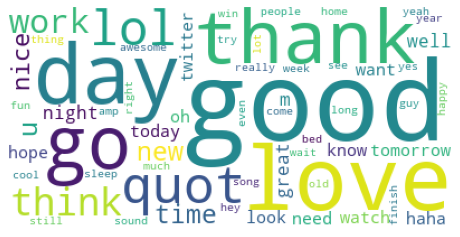

In [89]:
pk.wordcloud_plot(df.loc[df["target"]==4]["tweet_lemma_join"])

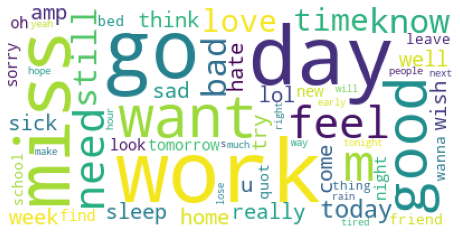

In [90]:
pk.wordcloud_plot(df.loc[df["target"]==0]["tweet_lemma_join"])

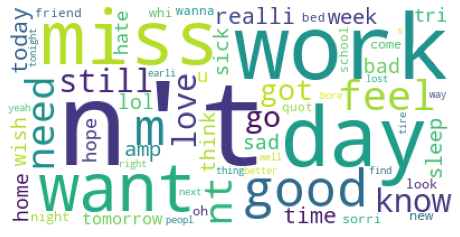

In [91]:
pk.wordcloud_plot(df.loc[df["target"]==0]["tweet_stem_join"])

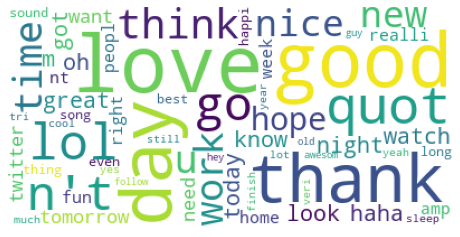

In [92]:
pk.wordcloud_plot(df.loc[df["target"]==4]["tweet_stem_join"])

Nous conservons donc la méthode de lemmatisation. Nous pouvons supprimer les colonnes contenant les données de stemming.

In [93]:
df = df.drop(["tweet_stem", "tweet_stem_join"], axis=1)

In [94]:
df.head(2)

,target,identity,date,username,tweet,tweet_clean,tweet_lemma,tweet_lemma_join,target_lib
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...",know sphincter oddi dysfunction pls send link ...,Negative
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good","(not, lookin, good, Mr., Sun, not, lookin, good)","[not, lookin, good, Mr., Sun, not, lookin, good]",not lookin good Mr. Sun not lookin good,Negative


La technique de lemmatization supprime surement des commentaires qui n'ont pas de sens tel que "I will go".
Nous supprimons donc les lignes vides.

In [95]:
df = df.loc[df["tweet_lemma"] != np.array(0)]

In [96]:
df.shape

(1589, 9)

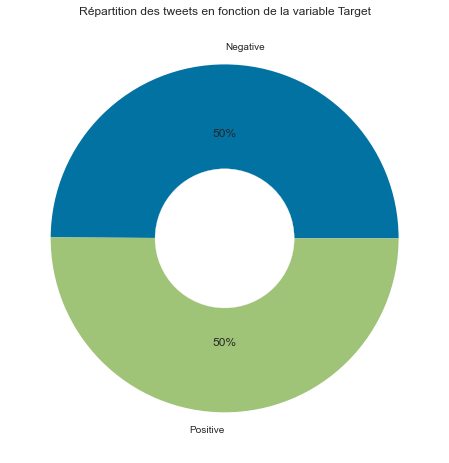

In [97]:
graph_circle(df["target_lib"], "Target",
                 "Répartition des tweets en fonction de la variable Target")

## Feature engineering

Deux méthodes : Glove, Fasttext

### Commençons par Glove

- Algorithme pour l'incorporation de mots :
- Prétraitez les données textuelles.
- Créé le dictionnaire.
- Parcourir le fichier glove d'une dimension précise et comparer chaque mot avec tous les mots du dictionnaire,
- si une correspondance se produit, copiez le vecteur équivalent du gant et collez-le dans embedding_matrix à l'index correspondant.

La matrice d'intégration est une matrice dont la taille de ligne est égale au nombre de mots uniques dans le document et dont la taille de colonne correspond à la dimension du vecteur d'intégration. Ainsi, afin de construire une matrice d'intégration, il faut soit créer les vecteurs d'intégration de mots, soit utiliser des intégrations de mots pré-formés. Dans cet exemple, nous allons lire un fichier d'incorporation de mots fictifs et construire la matrice.

In [7]:
df.head(2)

,Unnamed: 0,target,identity,date,username,tweet,tweet_clean,tweet_lemma,tweet_lemma_join,target_lib,cg_positive,cg_neutral,cg_negative
0,0,0.0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,know sphincter oddi dysfunction pls send link ...,"['know', 'sphincter', 'oddi', 'dysfunction', '...",know sphincter oddi dysfunction pls send link ...,Negative,0.01,0.21,0.78
1,1,0.0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",not lookin good Mr. Sun not lookin good,"['not', 'lookin', 'good', 'Mr.', 'Sun', 'not',...",not lookin good Mr. Sun not lookin good,Negative,0.01,0.00,0.99


In [11]:
df["tweet_lemma"][0]

'[\'know\', \'sphincter\', \'oddi\', \'dysfunction\', \'pls\', \'send\', \'link\', "Dx\'d", \'but\', \'unable\', \'ERCP\']'

In [12]:
# Change the current working directory
os.chdir(r'D:Users\Aurel\OneDrive_N\OneDrive\_WORK0\IngenieurIA\projets\Projet7BadBuzz\OP_Project7')

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'D:Users\\Aurel\\OneDrive_N\\OneDrive\\_WORK0\\IngenieurIA\\projets\\Projet7BadBuzz\\OP_Project7'

In [43]:
import numpy as np


class Embeddings():
    """
    A class to read the word embedding file and to create the word embedding matrix
    """

    def __init__(self, path, vector_dimension):
        self.path = path 
        self.vector_dimension = vector_dimension
    
    @staticmethod
    def get_coefs(word, *arr): 
        return word, np.asarray(arr, dtype='float32')

    def get_embedding_index(self):
        embeddings_index = dict(self.get_coefs(*o.split(" ")) for o in open(self.path, errors='ignore'))
        return embeddings_index

    def create_embedding_matrix(self, tokenizer, max_features):
        """
        A method to create the embedding matrix
        """
        model_embed = self.get_embedding_index()

        embedding_matrix = np.zeros((max_features + 1, self.vector_dimension))
        for word, index in tokenizer.word_index.items():
            if index > max_features:
                break
            else:
                try:
                    embedding_matrix[index] = model_embed[word]
                except:
                    continue
        return embedding_matrix

In [44]:
def ml_pipeline_divide_data(df):
    data=df.copy()
    data2=data.copy()  
    X=data2[["tweet_lemma_join"]].loc[data["target"].notnull()]
    del data2["target"]
    Y=data["target"].loc[data["target"].notnull()]
    return X,Y

In [45]:
def ml_step1_ech(df):
    X, Y = ml_pipeline_divide_data(df)
    X_train, X_test, y_train, y_test = pk_multi_sup.pipelineModel_TrainingSet(X, Y, 0, 0.3)
    # Creating the padded input for the deep learning model
    max_len = np.max([len(text) for text in X_train])
    TextToTensor_instance = TextToTensor(
            tokenizer=tokenizer, 
            max_len=max_len
            )
    X_train = TextToTensor_instance.string_to_tensor(X_train)
   # X_test = TextToTensor_instance.string_to_tensor(X_test)
    return X_train, X_test, y_train, y_test

In [46]:
X_train = df["tweet_lemma_join"]# Texte 


In [47]:
X_train

0       know sphincter oddi dysfunction pls send link ...
1                 not lookin good Mr. Sun not lookin good
2         Emily think would cool blanket pillow come help
3          nothing ever help Iran give illusion help Iran
4       drunk miss good friend wed love side drunk kin...
                              ...                        
1584    naah sweet person never harm hope say nice rit...
1585    got nail look like zebra not sound cute but re...
1586                                           follow Mya
1587    closed phone finger hurt like bitch lol go bed...
1588    not wait tomorrow breakfast car ride massage g...
Name: tweet_lemma_join, Length: 1589, dtype: object

In [48]:
Y_train = df["target"] # Libellé

In [49]:
X_train.shape

(1589,)

In [50]:
Y_train.shape

(1589,)

In [51]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [52]:
embed_path = 'Input\\embeddings\\glove.6B\\glove.6B.300d.txt' #glove.6B.300d
embed_dim = 300


In [53]:
# Creating the embedding matrix
embedding = Embeddings(embed_path, embed_dim)
embedding_matrix_glove = embedding.create_embedding_matrix(tokenizer, len(tokenizer.word_counts))

In [54]:
embedding_matrix_glove

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0083903 ,  0.28769001, -0.23466   , ..., -0.66409999,
         0.10303   ,  0.1219    ],
       [-0.0093601 ,  0.22789   , -0.10275   , ..., -0.51568002,
        -0.035701  ,  0.0074737 ],
       ...,
       [-0.13891   , -0.083528  , -0.11974   , ...,  0.40112999,
         0.24844   ,  0.96111   ],
       [-0.11415   ,  0.33406001,  0.084096  , ...,  0.50097001,
        -0.064236  ,  0.10605   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### Passons à Fasttext

In [55]:
import gensim.downloader as api
import numpy as np
import tensorflow as tf

fasttext = api.load("fasttext-wiki-news-subwords-300")
embedding_dim = 300

In [56]:
class Embeddings_Model():
    """
    A class to read the word embedding model and to create the word embedding matrix
    """

    def __init__(self, model, vector_dimension):
        self.model = model 
        self.vector_dimension = vector_dimension

    def get_embedding_index(self):
        embeddings_index = self.model
        return embeddings_index

    def create_embedding_matrix(self, tokenizer, max_features):
        """
        A method to create the embedding matrix
        """
        model_embed = self.get_embedding_index()

        embedding_matrix = np.zeros((max_features + 1, self.vector_dimension))
        for word, index in tokenizer.word_index.items():
            if index > max_features:
                break
            else:
                try:
                    embedding_matrix[index] = model_embed[word]
                except:
                    continue
        return embedding_matrix

In [57]:
# Creating the embedding matrix
embedding = Embeddings_Model(fasttext, embedding_dim)
embedding_matrix_fasttext = embedding.create_embedding_matrix(tokenizer, len(tokenizer.word_counts))

In [58]:
embedding_matrix_fasttext.shape

(3622, 300)

## Modèle avancé

### Réseau de neurone simple

In [60]:
X_train

0       know sphincter oddi dysfunction pls send link ...
1                 not lookin good Mr. Sun not lookin good
2         Emily think would cool blanket pillow come help
3          nothing ever help Iran give illusion help Iran
4       drunk miss good friend wed love side drunk kin...
                              ...                        
1584    naah sweet person never harm hope say nice rit...
1585    got nail look like zebra not sound cute but re...
1586                                           follow Mya
1587    closed phone finger hurt like bitch lol go bed...
1588    not wait tomorrow breakfast car ride massage g...
Name: tweet_lemma_join, Length: 1589, dtype: object

In [61]:
vocab_size = len(tokenizer.word_index) + 1

In [62]:
#Load Packages
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Embedding

model = Sequential()
model.add(Embedding( 
  input_dim=3622, 
  output_dim=300, 
  input_length=115, 
  weights= [embedding_matrix_fasttext],
  trainable = False,
  mask_zero= True )) 
model.add(Dense(32, input_dim=3622))
###model.add(Flatten())
model.add(Activation('relu'))
#model.add(Dense(25,kernel_initializer='normal',activation='relu'))
#model.add(Dense(25,kernel_initializer='normal',activation='relu'))
#model.add(Dense(113,activation='softmax'))binary_crossentropy
#model.compile(loss='mse',optimizer ='adam',metrics=['AUC'])
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',loss ='binary_crossentropy',metrics=['AUC'])

In [63]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 115) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
embedding (None, 115) float32
dense (None, 115, 300) float32
activation (None, 115, 32) float32
flatten (None, 115, 32) float32
dense_1 (None, 3680) float32


[None, None, None, None, None]

In [64]:
df.head(2)

,Unnamed: 0,target,identity,date,username,tweet,tweet_clean,tweet_lemma,tweet_lemma_join,target_lib,cg_positive,cg_neutral,cg_negative
0,0,0.0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,know sphincter oddi dysfunction pls send link ...,"['know', 'sphincter', 'oddi', 'dysfunction', '...",know sphincter oddi dysfunction pls send link ...,Negative,0.01,0.21,0.78
1,1,0.0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",not lookin good Mr. Sun not lookin good,"['not', 'lookin', 'good', 'Mr.', 'Sun', 'not',...",not lookin good Mr. Sun not lookin good,Negative,0.01,0.00,0.99


In [65]:
def ml_pipeline_divide_data(df):
    data=df.copy()
    data2=data.copy()  
    X=data2["tweet_lemma_join"].loc[pd.isna(data["target"])==False]
    del data2["target"]
    Y=data["target"].loc[pd.isna(data["target"])==False]
    return X,Y

In [66]:
from keras_preprocessing.sequence import pad_sequences
#from keras.preprocessing.sequence import pad_sequences

class TextToTensor():

    def __init__(self, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len

    def string_to_tensor(self, string_list: list) -> list:
        """
        A method to convert a string list to a tensor for a deep learning model
        """    
        string_list = self.tokenizer.texts_to_sequences(string_list)
        string_list = pad_sequences(string_list, maxlen=self.max_len)
        
        return string_list

In [67]:
# Creating the padded input for the deep learning model
def ml_transform(X):
    # Getting the longest sentence
    max_len = np.max([len(text) for text in X])
    TextToTensor_instance = TextToTensor(
                tokenizer=tokenizer,
                max_len=max_len
                )
    X = TextToTensor_instance.string_to_tensor(X)
    return X
# X_test = TextToTensor_instance.string_to_tensor(X_test)

In [68]:
def ml_step1_ech(df):
        X, Y = ml_pipeline_divide_data(df)
        X_train, X_test, y_train, y_test = pk_multi_sup.pipelineModel_TrainingSet(X, Y, 0, 0.3)
        max_len = np.max([len(text) for text in X_train])
        TextToTensor_instance = TextToTensor(
                tokenizer=tokenizer,
                max_len=max_len
                )
        X_train = TextToTensor_instance.string_to_tensor(X_train)
        # Creating the padded input for the deep learning model
        # X_train = ml_transform(X_train)
        X_test = TextToTensor_instance.string_to_tensor(X_test)
        # X_test = TextToTensor_instance.string_to_tensor(X_test)
        return X_train, X_test, np.array(y_train), np.array(y_test)

In [69]:
X_train.shape

(1589,)

In [70]:
df.head(2)

,Unnamed: 0,target,identity,date,username,tweet,tweet_clean,tweet_lemma,tweet_lemma_join,target_lib,cg_positive,cg_neutral,cg_negative
0,0,0.0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,know sphincter oddi dysfunction pls send link ...,"['know', 'sphincter', 'oddi', 'dysfunction', '...",know sphincter oddi dysfunction pls send link ...,Negative,0.01,0.21,0.78
1,1,0.0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good",not lookin good Mr. Sun not lookin good,"['not', 'lookin', 'good', 'Mr.', 'Sun', 'not',...",not lookin good Mr. Sun not lookin good,Negative,0.01,0.00,0.99


In [71]:
X_train, X_test, y_train, y_test = ml_step1_ech(df)

In [72]:
X_train.shape

(1112, 115)

In [73]:
y_train.shape

(1112,)

In [74]:
X_test.shape

(477, 115)

In [75]:
y_test.shape

(477,)

In [76]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 300)          1086600   
                                                                 
 dense (Dense)               (None, 115, 32)           9632      
                                                                 
 activation (Activation)     (None, 115, 32)           0         
                                                                 
 flatten (Flatten)           (None, 3680)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3681      
                                                                 
Total params: 1,099,913
Trainable params: 13,313
Non-trainable params: 1,086,600
_________________________________________________________________


In [77]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=113)

Epoch 1/10
10/10 [==============================] - 3s 55ms/step - loss: 0.6919 - auc: 0.5415 - val_loss: 0.6933 - val_auc: 0.5414
Epoch 2/10
10/10 [==============================] - 0s 19ms/step - loss: 0.6861 - auc: 0.6394 - val_loss: 0.6922 - val_auc: 0.5432
Epoch 3/10
10/10 [==============================] - 0s 18ms/step - loss: 0.6806 - auc: 0.6641 - val_loss: 0.6894 - val_auc: 0.5531
Epoch 4/10
10/10 [==============================] - 0s 18ms/step - loss: 0.6740 - auc: 0.6693 - val_loss: 0.6861 - val_auc: 0.5666
Epoch 5/10
10/10 [==============================] - 0s 19ms/step - loss: 0.6653 - auc: 0.6949 - val_loss: 0.6836 - val_auc: 0.5868
Epoch 6/10
10/10 [==============================] - 0s 19ms/step - loss: 0.6570 - auc: 0.7198 - val_loss: 0.6816 - val_auc: 0.6043
Epoch 7/10
10/10 [==============================] - 0s 17ms/step - loss: 0.6477 - auc: 0.7338 - val_loss: 0.6794 - val_auc: 0.6199
Epoch 8/10
10/10 [==============================] - 0s 16ms/step - loss: 0.6381 - a

In [78]:
history.history

{'loss': [0.6919442415237427,
  0.6860557198524475,
  0.6805816888809204,
  0.674047589302063,
  0.6653037667274475,
  0.6570191979408264,
  0.647661030292511,
  0.6381126046180725,
  0.6264355778694153,
  0.6171016693115234],
 'auc': [0.5414789319038391,
  0.6393652558326721,
  0.664057731628418,
  0.6692659258842468,
  0.6948825120925903,
  0.7197514176368713,
  0.7337913513183594,
  0.7400142550468445,
  0.7578930854797363,
  0.7701867818832397],
 'val_loss': [0.6933410167694092,
  0.6922167539596558,
  0.6893545985221863,
  0.6861302256584167,
  0.6835914254188538,
  0.681633472442627,
  0.6794179081916809,
  0.6696515679359436,
  0.6683071255683899,
  0.6590242385864258],
 'val_auc': [0.5413743257522583,
  0.543154776096344,
  0.5530709028244019,
  0.5665568113327026,
  0.5868120193481445,
  0.6042732000350952,
  0.6198832988739014,
  0.6283538341522217,
  0.6443870067596436,
  0.6477189064025879]}

In [79]:
X_train.shape

(1112, 115)

In [80]:
X_test.shape

(477, 115)

In [81]:
y_test.shape

(477,)

In [82]:
history.history

{'loss': [0.6919442415237427,
  0.6860557198524475,
  0.6805816888809204,
  0.674047589302063,
  0.6653037667274475,
  0.6570191979408264,
  0.647661030292511,
  0.6381126046180725,
  0.6264355778694153,
  0.6171016693115234],
 'auc': [0.5414789319038391,
  0.6393652558326721,
  0.664057731628418,
  0.6692659258842468,
  0.6948825120925903,
  0.7197514176368713,
  0.7337913513183594,
  0.7400142550468445,
  0.7578930854797363,
  0.7701867818832397],
 'val_loss': [0.6933410167694092,
  0.6922167539596558,
  0.6893545985221863,
  0.6861302256584167,
  0.6835914254188538,
  0.681633472442627,
  0.6794179081916809,
  0.6696515679359436,
  0.6683071255683899,
  0.6590242385864258],
 'val_auc': [0.5413743257522583,
  0.543154776096344,
  0.5530709028244019,
  0.5665568113327026,
  0.5868120193481445,
  0.6042732000350952,
  0.6198832988739014,
  0.6283538341522217,
  0.6443870067596436,
  0.6477189064025879]}

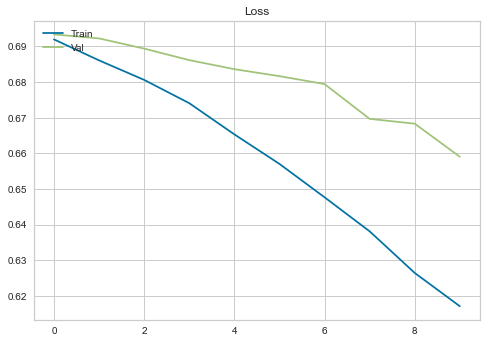

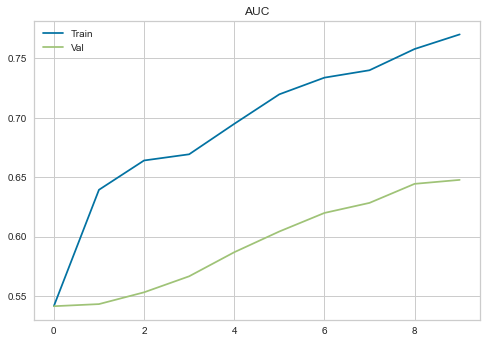

In [83]:
loss_curve = history.history["loss"]
acc_curve = history.history["auc"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_auc"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("AUC")
plt.show()

In [84]:
results = model.evaluate(X_test,y_test)

15/15 [==============================] - 0s 2ms/step - loss: 0.6590 - auc: 0.6477


In [85]:
results

[0.6590242981910706, 0.6477189064025879]

In [86]:
results

[0.6590242981910706, 0.6477189064025879]

In [89]:
y_prob = model.predict(X_test)

15/15 [==============================] - 0s 3ms/step


In [90]:
y_pred = np.where(y_prob > 0.5, 1, 0) 

In [92]:
import joblib

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe Roc')
    plt.legend()
    plt.show()


def pipeline_training_metrics(y_prob, y_test):
    # On créé un vecteur de prédiction à partir du vecteur de probabilités
    y_pred = np.where(y_prob > 0.5, 1, 0) 

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print(roc_auc)
    #print("false positive rate : ", false_positive_rate)
    #print("true positive rate : ", true_positive_rate)
    x_rate = false_positive_rate
    y_rate = true_positive_rate 

    # This is the ROC curve
    plot_roc_curve(x_rate,y_rate)
    
    CM = metrics.confusion_matrix(y_test, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    metier = (FN*0.1+FP*0.9)/(FN+FP+TN+TP)
    
    print('FULL Métrique Métier : ', metier)

    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
    #Matrice de confusion
    conf = metrics.confusion_matrix(y_test, y_pred)
    conf
    sns.heatmap(conf, square=True, annot=True, cbar=False)
            #, xticklabels=list(iris.target_names)
            #, yticklabels=list(iris.target_names))
    plt.xlabel('valeurs prédites')
    plt.ylabel('valeurs réelles')
    plt.title('Matrice de confusion %')
    plt.show()
    
    sns.heatmap(conf/np.sum(conf), annot=True, 
            fmt='.2%', cmap='Blues')
    plt.xlabel('valeurs prédites')
    plt.ylabel('valeurs réelles')
    plt.title('Matrice de confusion %')
    plt.show()
    
    print("\nSur le jeu de test auc : {:.3f}".format(metrics.roc_auc_score(y_test, y_pred)))
    print("\nSur le jeu de test f1_score : {:.3f}".format(metrics.f1_score(y_test, y_pred)))
    print("\nSur le jeu de test precision : {:.3f}".format(metrics.precision_score(y_test, y_pred)))
    print("\nSur le jeu de test recall : {:.3f}".format(metrics.recall_score(y_test, y_pred)))
    #


0.6025631985333004


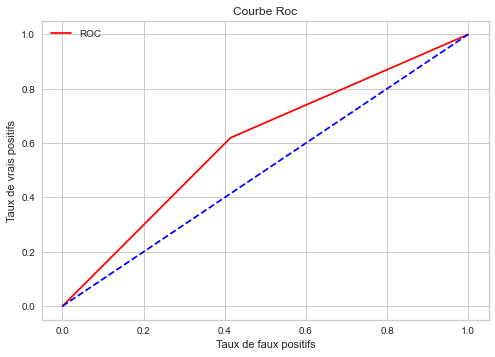

FULL Métrique Métier :  0.21425576519916142
Mean Absolute Error: 0.39832285115303984
Mean Squared Error: 0.39832285115303984
Root Mean Squared Error: 0.6311282366944454


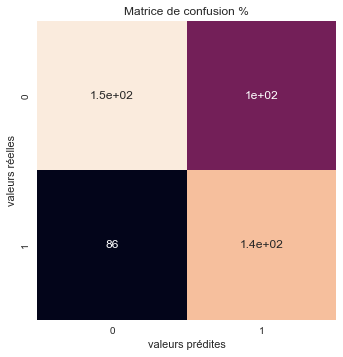

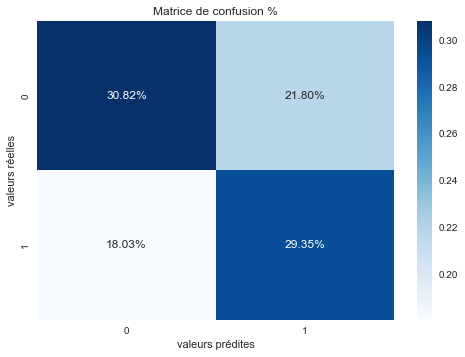


Sur le jeu de test auc : 0.603

Sur le jeu de test f1_score : 0.596

Sur le jeu de test precision : 0.574

Sur le jeu de test recall : 0.619


In [93]:
pipeline_training_metrics(y_prob, y_test)

## BILSTM

In [94]:
#Load Packages
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Bidirectional, TimeDistributed
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Embedding

model = Sequential()
model.add(Embedding( 
  input_dim=3622, 
  output_dim=300, 
  input_length=115, 
  weights= [embedding_matrix_fasttext],
  trainable = False,
  mask_zero= True )) 
model.add(Bidirectional(LSTM(20, return_sequences=True), input_dim=3622))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.add(Flatten())
model.compile(optimizer='rmsprop',loss ='binary_crossentropy',metrics=['AUC'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [95]:
history_bilstm = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=50,batch_size=113)

Epoch 1/50
10/10 [==============================] - 13s 387ms/step - loss: 0.6911 - auc: 0.5777 - val_loss: 0.6906 - val_auc: 0.5453
Epoch 2/50
10/10 [==============================] - 1s 114ms/step - loss: 0.6839 - auc: 0.6604 - val_loss: 0.6859 - val_auc: 0.5746
Epoch 3/50
10/10 [==============================] - 1s 114ms/step - loss: 0.6708 - auc: 0.6971 - val_loss: 0.6770 - val_auc: 0.6819
Epoch 4/50
10/10 [==============================] - 1s 115ms/step - loss: 0.6523 - auc: 0.7415 - val_loss: 0.6633 - val_auc: 0.6544
Epoch 5/50
10/10 [==============================] - 1s 119ms/step - loss: 0.6290 - auc: 0.7614 - val_loss: 0.6517 - val_auc: 0.6729
Epoch 6/50
10/10 [==============================] - 1s 115ms/step - loss: 0.6074 - auc: 0.7738 - val_loss: 0.6391 - val_auc: 0.7098
Epoch 7/50
10/10 [==============================] - 1s 113ms/step - loss: 0.5901 - auc: 0.7916 - val_loss: 0.6466 - val_auc: 0.6908
Epoch 8/50
10/10 [==============================] - 1s 117ms/step - loss: 0

In [96]:
history_bilstm.history

{'loss': [0.6911101937294006,
  0.6838827729225159,
  0.6707563400268555,
  0.6522542238235474,
  0.6289741396903992,
  0.6074186563491821,
  0.5901014804840088,
  0.5736559629440308,
  0.5558221340179443,
  0.544887125492096,
  0.5248053073883057,
  0.518692672252655,
  0.5032330751419067,
  0.48705407977104187,
  0.4800359010696411,
  0.4783393144607544,
  0.45693519711494446,
  0.4508610963821411,
  0.4438832104206085,
  0.42914772033691406,
  0.42428022623062134,
  0.41896751523017883,
  0.41271764039993286,
  0.39635032415390015,
  0.3917183578014374,
  0.40414780378341675,
  0.3745962679386139,
  0.3991886377334595,
  0.36651715636253357,
  0.3511136472225189,
  0.3649521470069885,
  0.34319889545440674,
  0.35594356060028076,
  0.32401391863822937,
  0.3409295082092285,
  0.32056382298469543,
  0.31174901127815247,
  0.3284261226654053,
  0.3159337341785431,
  0.29271143674850464,
  0.2933098077774048,
  0.31106770038604736,
  0.3055894374847412,
  0.2702714502811432,
  0.267196

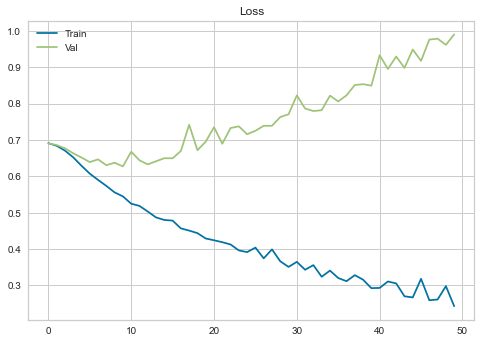

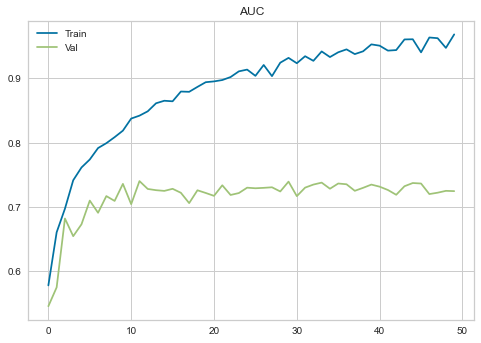

In [97]:
loss_curve = history_bilstm.history["loss"]
acc_curve = history_bilstm.history["auc"]

loss_val_curve = history_bilstm.history["val_loss"]
acc_val_curve = history_bilstm.history["val_auc"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("AUC")
plt.show()

In [107]:
y_prob = model.predict(X_test)

15/15 [==============================] - 0s 21ms/step


0.6755808623911433


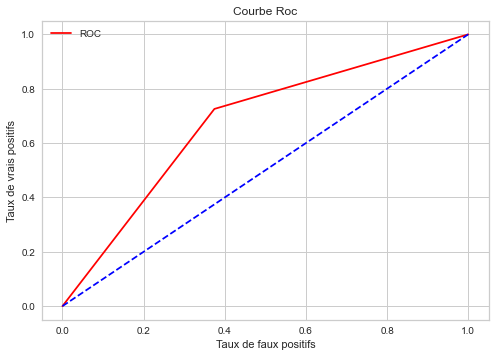

FULL Métrique Métier :  0.19035639412997907
Mean Absolute Error: 0.3270440251572327
Mean Squared Error: 0.3270440251572327
Root Mean Squared Error: 0.5718776312789587


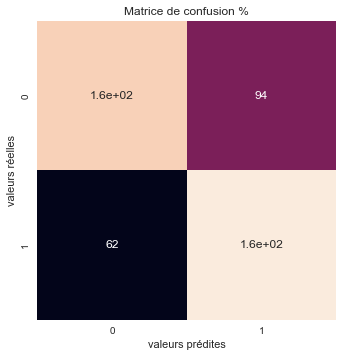

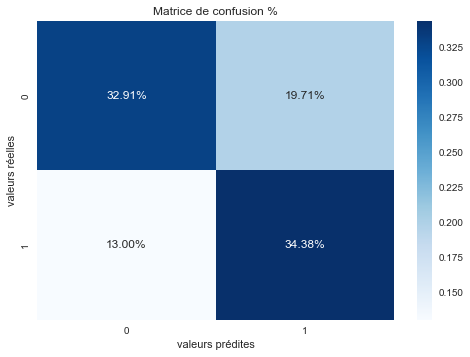


Sur le jeu de test auc : 0.676

Sur le jeu de test f1_score : 0.678

Sur le jeu de test precision : 0.636

Sur le jeu de test recall : 0.726


In [108]:
pipeline_training_metrics(y_prob, y_test)

## Bert

In [16]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [17]:
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig

In [18]:
num_classes=len(df.target.unique())

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)


loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at C:\Users\aurel/.cache\huggingface\transformers\45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at C:\Users\aurel/.cache\huggingface\transformers\c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\aurel/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005b

In [19]:
sent= 'how to train the model, lets look at how a trained model calculates its prediction.'
tokens=bert_tokenizer.tokenize(sent)
print(tokens)

['how', 'to', 'train', 'the', 'model', ',', 'lets', 'look', 'at', 'how', 'a', 'trained', 'model', 'calculate', '##s', 'its', 'prediction', '.']


In [20]:
sentences=df['tweet_lemma_join']
labels=df['target']
len(sentences),len(labels)

(1589, 1589)

In [21]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =64,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)
len(input_ids),len(attention_masks),len(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


(1589, 1589, 1589)

In [22]:
import pickle
print('Preparing the pickle file.....')

pickle_inp_path='./output/bert_inp.pkl'
pickle_mask_path='./output/bert_mask.pkl'
pickle_label_path='./output/bert_label.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))
 

Preparing the pickle file.....
Pickle files saved as  ./output/bert_inp.pkl ./output/bert_mask.pkl ./output/bert_label.pkl
Loading the saved pickle files..
Input shape (1589, 64) Attention mask shape (1589, 64) Input label shape (1589,)


In [23]:

train_inp,val_inp,train_label,val_label,train_mask,val_mask=pk_multi.train_test_split(input_ids,labels,attention_masks,test_size=0.3)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

 


Train inp shape (1112, 64) Val input shape (477, 64)
Train label shape (1112,) Val label shape (477,)
Train attention mask shape (1112, 64) Val attention mask shape (477, 64)


In [24]:
log_dir='tensorboard_data/tb_bert'
model_save_path='./output/models/bert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),tf.keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('auc')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [25]:

history=bert_model.fit([train_inp,train_mask],train_label,batch_size=32,epochs=4,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)


Epoch 1/4
35/35 [==============================] - 278s 7s/step - loss: 0.6746 - auc: 0.5818 - val_loss: 0.6143 - val_auc: 0.6792
Epoch 2/4
35/35 [==============================] - 251s 7s/step - loss: 0.5434 - auc: 0.7401 - val_loss: 0.5822 - val_auc: 0.6876
Epoch 3/4
35/35 [==============================] - 245s 7s/step - loss: 0.3768 - auc: 0.8336 - val_loss: 0.6005 - val_auc: 0.7149
Epoch 4/4
35/35 [==============================] - 242s 7s/step - loss: 0.2192 - auc: 0.9173 - val_loss: 0.6851 - val_auc: 0.7191


In [26]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [27]:

log_dir='tensorboard_data/bert_model'
%tensorboard --logdir {log_dir}

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "D:\ProgramFiles\Anaconda3\envs\venv_007\lib\site-packages\importlib_metadata\_compat.py", line 9, in <module>
    from typing import Protocol
ImportError: cannot import name 'Protocol' from 'typing' (D:\ProgramFiles\Anaconda3\envs\venv_007\lib\typing.py)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\ProgramFiles\Anaconda3\envs\venv_007\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\ProgramFiles\Anaconda3\envs\venv_007\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\ProgramFiles\Anaconda3\envs\venv_007\Scripts\tensorboard.exe\__main__.py", line 4, in <module>
  File "D:\ProgramFiles\Anaconda3\envs\venv_007\lib\site-packages\tensorboard\main.py", line 27, in <module>
    from tensorboard import default
  File "D:\ProgramFiles\Anaconda3\envs

In [31]:
from sklearn.metrics import confusion_matrix,f1_score,classification_report

model_save_path='./output/models/bert_model.h5'

trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_save_path)

preds = trained_model.predict([val_inp,val_mask],batch_size=32)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\aurel/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/tf_model.h5 from cac

15/15 [==============================] - 31s 2s/step


In [37]:
pred_labels = np.argmax(preds.logits, axis=1)
#pred_labels = preds.arg_max(axis=1)

In [38]:

f1 = metrics.f1_score(val_label,pred_labels)
print('F1 score',f1)
print('Classification Report')
print(classification_report(val_label,pred_labels))

print('Training and saving built model.....')   

F1 score 0.6149870801033592
Classification Report
              precision    recall  f1-score   support

         0.0       0.61      0.92      0.74       227
         1.0       0.87      0.48      0.61       250

    accuracy                           0.69       477
   macro avg       0.74      0.70      0.68       477
weighted avg       0.75      0.69      0.67       477

Training and saving built model.....


In [39]:
metrics.confusion_matrix(val_label,pred_labels)

array([[209,  18],
       [131, 119]], dtype=int64)

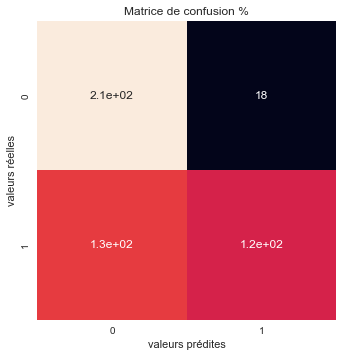

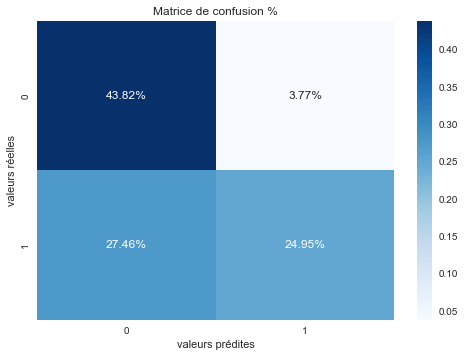

In [41]:
    #Matrice de confusion
    conf = metrics.confusion_matrix(val_label,pred_labels)
    conf
    sns.heatmap(conf, square=True, annot=True, cbar=False)
            #, xticklabels=list(iris.target_names)
            #, yticklabels=list(iris.target_names))
    plt.xlabel('valeurs prédites')
    plt.ylabel('valeurs réelles')
    plt.title('Matrice de confusion %')
    plt.show()
    
    sns.heatmap(conf/np.sum(conf), annot=True, 
            fmt='.2%', cmap='Blues')
    plt.xlabel('valeurs prédites')
    plt.ylabel('valeurs réelles')
    plt.title('Matrice de confusion %')
    plt.show()

## Service cognitif Azure : Analyse de sentiment

KEYS IN KEYVUALT OR UMI

In [ ]:
from azure.identity import DefaultAzureCredential
from azure.keyvault.keys import KeyClient

credential = DefaultAzureCredential()

key_client = KeyClient(vault_url="https://my-key-vault.vault.azure.net/", credential=credential)
key = key_client.get_key("key-name")
print(key.name)

In [98]:
#################key vault

cog_key = os.getenv('cog_key')
cog_endpoint = os.getenv('cog_endpoint')

#print('Ready to use cognitive services at {} using key {}'.format(cog_endpoint, cog_key))


In [99]:
import os
from azure.ai.textanalytics import TextAnalyticsClient

from azure.cognitiveservices.language.textanalytics import TextAnalyticsClient
from msrest.authentication import CognitiveServicesCredentials



In [100]:
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

# Authenticate the client using your key and endpoint 
def authenticate_client():
    ta_credential = AzureKeyCredential(cog_key)
    text_analytics_client = TextAnalyticsClient(
            endpoint=cog_endpoint, 
            credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

In [101]:
def azure_cg(text, score):
    documents = []
    documents.append(text)
    response = client.analyze_sentiment(documents=documents)[0]
    if score == 1:
        return response.confidence_scores.positive
    elif score == 2:
        return response.confidence_scores.neutral
    elif score == 3:
        return response.confidence_scores.negative

In [102]:
df.head(2)

,target,identity,date,username,tweet,tweet_clean,tweet_lemma,tweet_lemma_join,target_lib
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...",know sphincter oddi dysfunction pls send link ...,Negative
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good","(not, lookin, good, Mr., Sun, not, lookin, good)","[not, lookin, good, Mr., Sun, not, lookin, good]",not lookin good Mr. Sun not lookin good,Negative


In [153]:
df["cg_positive"] = df["tweet"].progress_apply(lambda x: azure_cg(x, 1))

  0%|          | 0/1589 [00:00<?, ?it/s]

In [154]:
gc.collect()

51875

In [155]:
df.head(2)

,target,identity,date,username,tweet,tweet_clean,tweet_lemma,tweet_lemma_join,target_lib,cg_positive,cg_neutral,cg_negative
0,0,2063963976,Sun Jun 07 04:45:03 PDT 2009,Oh2BeTall,@drallenlubell do know anything about sphincte...,"(know, sphincter, oddi, dysfunction, pls, send...","[know, sphincter, oddi, dysfunction, pls, send...",know sphincter oddi dysfunction pls send link ...,Negative,0.01,0.06,0.93
1,0,2018659971,Wed Jun 03 10:18:42 PDT 2009,kawtreenah,"its not lookin good Mr. Sun, its not lookin good","(not, lookin, good, Mr., Sun, not, lookin, good)","[not, lookin, good, Mr., Sun, not, lookin, good]",not lookin good Mr. Sun not lookin good,Negative,0.01,0.01,0.98


In [156]:
df["cg_neutral"] = df["tweet"].progress_apply(lambda x: azure_cg(x, 2))

  0%|          | 0/1589 [00:00<?, ?it/s]

In [157]:
df["cg_negative"] = df["tweet"].progress_apply(lambda x: azure_cg(x, 3))

  0%|          | 0/1589 [00:00<?, ?it/s]

In [198]:
# df.to_csv("output/sample_cg.csv") >> sur tweet_lemma_join
# df.to_csv("output/sample_cg_v2.csv") # sur tweet

In [15]:
df = pd.read_csv("output/sample_cg_v2.csv")

In [5]:
gc.collect()

21

In [174]:
df.tail(3)

,target,identity,date,username,tweet,tweet_clean,tweet_lemma,tweet_lemma_join,target_lib,cg_positive,cg_neutral,cg_negative
1597,NaN,1694091879,Mon May 04 01:02:50 PDT 2009,SDoT84,I am following Mya,"(following, Mya)","[follow, Mya]",follow Mya,Positive,0.02,0.95,0.03
1598,NaN,1978674036,Sun May 31 00:05:41 PDT 2009,chellebelle12xo,closed my phone on my finger and it hurt like...,"(closed, phone, finger, hurt, like, bitch, lol...","[closed, phone, finger, hurt, like, bitch, lol...",closed phone finger hurt like bitch lol go bed...,Positive,0.38,0.10,0.52
1599,NaN,1686803025,Sun May 03 06:49:31 PDT 2009,KyngDyngalyng,"I can't wait until tomorrow...breakfast,car ri...","(n't, wait, tomorrow, breakfast, car, riding, ...","[not, wait, tomorrow, breakfast, car, ride, ma...",not wait tomorrow breakfast car ride massage g...,Positive,0.77,0.20,0.03


Nous modifions la valeur 4 à 1 afin que ce soit plus pratique avec l'utilisation des algorithmes. 1 = tweet positif et 0 tweet negatif

In [111]:
df2 = df.copy()

In [175]:
df['target'] = df['target'].map({0:0,
                             pd.NaN:1},
                             na_action=None)

AttributeError: module 'pandas' has no attribute 'NaN'

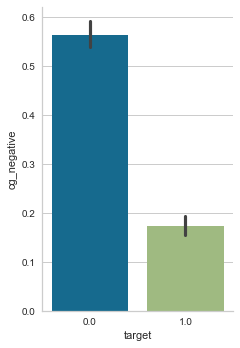

In [177]:
sns.catplot(x="target", y="cg_negative",
                data=df, kind="bar",
                 aspect=.7)

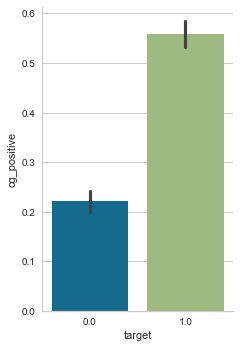

In [178]:
sns.catplot(x="target", y="cg_positive",
                data=df, kind="bar",
                 aspect=.7)



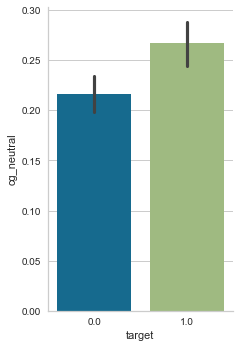

In [179]:
sns.catplot(x="target", y="cg_neutral",
                data=df, kind="bar",
                 aspect=.7)

### Modèle Simple : Regression logistique VS RandomForest

Nous séparons notre jeu de données en train et en test

In [167]:
def pipeline_divide_data(df):
    data=df.copy()
    data2=data.copy()
    X=data2[["cg_positive", "cg_neutral", "cg_negative"]].loc[data["target"].notnull()]
    del data2["target"]
    Y=data["target"].loc[data["target"].notnull()]
    return X,Y

Nous voulons détecter les commentaires négéatifs pour pouvoir agir. Nous allons créer une nouvelle métrique dans laquelle nous allons donc accentuer la non détection des commentaires négatifs.

Nous testons deux méthodes : Regression logistique et l'arbre de decision : Random forest

Pour cela, nous utilisons Hyperopt pour choisir les meilleures paramètres possibles

In [180]:
import mlflow
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
# fonction pour diviser le dataframe en training set
def step1_ech(df):
    X, Y = pipeline_divide_data(df)
    X_train, X_test, y_train, y_test = pk_multi_sup.pipelineModel_TrainingSet(X, Y, 0, 0.3)
    return X_train, X_test, y_train, y_test

####score pour fonction metier >> on veut detecter les commentaires negatives afin de pouvoir agir, nous accentuons donc le poids pour les Faux negatifs.
def fmetric_metier(y_true, y_pred):
    CM = metrics.confusion_matrix(y_true, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    metier = (FN*0.1+FP*0.9)/(FN+FP+TN+TP)
    
    print('FULL Métrique Métier : ', metier)
    return metier

metric_history = []
best_metric_history_n = []
feat_imp_df = pd.DataFrame()
feat_imp_df_history = []


###creation de fonction pour le tuning des hyperparamètres
def objective(params, X, y):
    gc.collect()
    print("------------------------------------------------")
    print("--------------params : ", params)
    #del params['type']
    classifier_type = params['type']
    #maxd=params['max_depthg']
    #del params['max_depthg']
    del params['type']
    
    ## Correction des paramètres identiques
    if 'max_depthg' in params:
        params["max_depth"]=int(params["max_depthg"])
        params["n_estimators"]=int(params["n_estimatorsg"])
        del params["max_depthg"]
        del params["n_estimatorsg"]
        
    if classifier_type == 'rf':
        clf = RandomForestClassifier(**params)
    elif (classifier_type == 'logreg'):
        clf = LogisticRegression(**params)
    else:
        return 0
    feat_imp_df = pd.DataFrame()

    auc_fold=[]
    metier_fold=[]
    cv = StratifiedKFold(n_splits=3)
    i=1
    t0 = time.time()
    for train_idx, test_idx, in cv.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

                #standardisation
        std_scale = StandardScaler().fit(X_train)
        X_train = std_scale.fit_transform(X_train)
        clf.fit(X_train, y_train)  
            
        y_prob = clf.predict_proba(X_test)[:,1] 
                
        # On créé un vecteur de prédiction à partir du vecteur de probabilités
        y_pred = np.where(y_prob > 0.5, 1, 0) 
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        metier_c=fmetric_metier(y_test, y_pred)
        auc_fold.append(roc_auc)
        metier_fold.append(metier_c)
        print(f'For fold {i}:')
        print(f'AUC: {roc_auc}')
        print(f'f1-score: {metrics.f1_score(y_test, y_pred)}')
        print(f'score métier:{metier_c}')
        fold_importance_df = pd.DataFrame()
        if (classifier_type != 'logreg'):
            fold_importance_df["classifier_type"] = classifier_type
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = i + 1
            if len(feat_imp_df)>0:
                feat_imp_df = pd.concat([feat_imp_df, fold_importance_df], axis=0)
            else:
                feat_imp_df = fold_importance_df
                feat_imp_df_history.append(feat_imp_df)
        gc.collect()
        i+=1
        
    time_res=time.time() - t0
    auc_m=np.mean(auc_fold)
    metier=np.mean(metier_fold)
    print("metric auc moyenne :", auc_m)
    print("taux metier moyen :", metier)
    print("temps calcul :", time_res)

    if len(best_metric_history_n)>0:
        best_metric = max(best_metric_history_n)
    else:
        best_metric=auc_m

    print("best_metric : ", best_metric)
    if auc_m > best_metric:
        best_metric=auc_m

    metric_history.append({'classifier_type':classifier_type, 'auc':auc_m,'metier':metier, 'time':time_res, 'params':params})
    best_metric_history_n.append(best_metric)

    #Because fmin() tries to minimize the objective, this function must return the negative accuracy. 
    return {'loss': 1-auc_m, 'status': STATUS_OK}


search_space = hp.choice('classifier_type', [
    {
        'type': 'rf',
        'max_depth': hp.choice('max_depth', range(3,10)),
        'n_estimators': hp.choice('n_estimators', range(100,300)),#nb d'arbres dans la forêt
        'max_features': hp.choice('max_features', range(1, 3)),#nb de variables max pour diviser un noeud
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1,0.4), #nb de points de données placées dans un noeud avec qu'il soit divisé
        'min_samples_split': hp.choice('min_samples_split', range(2,12)) #nb minimal de points de données autorisées dans un noeud de feuille
       # 'criterion': hp.choice('criterion', ['gini', 'entropy'])
        #bootstrap > avec ou sans remplacement
    },
    {
        'type': 'logreg',
        'C': hp.uniform('LR_C', 0.1,1.0), # force de la penalité
        'solver': hp.choice('solver', ['liblinear']),#, 'lbfgs'
        'penalty' : hp.choice('penalty', ['l1','l2'])
    }
])


#Nous allons restreindre les colonnes sur la regression logistique, nous testerons les features obtenues grâce aux méthodes statistiques et celles sorties via le LGBM.
def score_model(X_train, y_train):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    scores = []
    i=0
    print("------------------------------------------")
    ###hyperopt tuning
    with mlflow.start_run():
            best_result = fmin(
                                partial(objective, 
                                        X=X_train, 
                                        y=y_train),
                                    space=search_space,
                                    algo=tpe.suggest,
                                    max_evals=5
                                    #trials=SparkTrials()
            )
    gc.collect()
    scores.append(best_result)
    return np.array(scores)


def SearchModel(df, target):
    X, Y = pipeline_divide_data(df)
    X_train, X_test, y_train, y_test=step1_ech(df)
    result=score_model(X_train, y_train)
    return result, X_train, y_train, X_test, y_test

In [181]:
result, X_train, y_train, X_test, y_test = SearchModel(df, "target")

------------------------------------------
------------------------------------------------     
--------------params :                               
{'max_depth': 7, 'max_features': 1, 'min_samples_leaf': 0.2932615820869342, 'min_samples_split': 3, 'n_estimators': 212, 'type': 'rf'}
FULL Métrique Métier :                               
0.05121293800539083                                  
For fold 1:                                          
AUC: 0.5                                             
f1-score: 0.0                                        
score métier:0.05121293800539083                     
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                               
0.05121293800539083                                  
For fold 2:                                          
AUC: 0.5                                             
f1-score: 0.0                                        
score métier:0.05121293800539083                     
  0%|          | 0/5 [00:01<?, ?trial/s, best loss=?]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                               
0.051351351351351354                                 
For fold 3:                                          
AUC: 0.5                                             
f1-score: 0.0                                        
score métier:0.051351351351351354                    
  0%|          | 0/5 [00:02<?, ?trial/s, best loss=?]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




metric auc moyenne :                                 
0.5                                                  
taux metier moyen :                                  
0.05125907578737767                                  
temps calcul :                                       
2.1747682094573975                                   
best_metric :                                        
0.5                                                  
------------------------------------------------                
--------------params :                                          
{'C': 0.5038520158015879, 'penalty': 'l2', 'solver': 'liblinear', 'type': 'logreg'}
FULL Métrique Métier :                                          
0.13989218328840972                                             
For fold 1:                                                     
AUC: 0.7430648444315208                                         
f1-score: 0.7570332480818414                                    
score métier:0.13989218328840

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




FULL Métrique Métier :                                          
0.20215633423180593                                             
For fold 2:                                                     
AUC: 0.720979936027915                                          
f1-score: 0.7681818181818183                                    
score métier:0.20215633423180593                                
 20%|██        | 1/5 [00:03<00:09,  2.41s/trial, best loss: 0.5]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




FULL Métrique Métier :                                          
0.15405405405405406                                             
For fold 3:                                                     
AUC: 0.7334795321637427                                         
f1-score: 0.755                                                 
score métier:0.15405405405405406                                
 20%|██        | 1/5 [00:03<00:09,  2.41s/trial, best loss: 0.5]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




metric auc moyenne :                                            
0.7325081042077262                                              
taux metier moyen :                                             
0.16536752385808992                                             
temps calcul :                                                  
0.9504575729370117                                              
best_metric :                                                   
0.5                                                             
------------------------------------------------                                
--------------params :                                                          
{'max_depth': 7, 'max_features': 2, 'min_samples_leaf': 0.3722936012377335, 'min_samples_split': 5, 'n_estimators': 186, 'type': 'rf'}
FULL Métrique Métier :                                                          
0.4390835579514825                                                              
For fold 1:          

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.4390835579514825                                                              
For fold 2:                                                                     
AUC: 0.5                                                                        
f1-score: 0.6773618538324421                                                    
score métier:0.4390835579514825                                                 
 40%|████      | 2/5 [00:04<00:05,  1.74s/trial, best loss: 0.26749189579227384]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.43783783783783786                                                             
For fold 3:                                                                     
AUC: 0.5                                                                        
f1-score: 0.6785714285714285                                                    
score métier:0.43783783783783786                                                
 40%|████      | 2/5 [00:05<00:05,  1.74s/trial, best loss: 0.26749189579227384]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




metric auc moyenne :                                                            
0.5                                                                             
taux metier moyen :                                                             
0.438668317913601                                                               
temps calcul :                                                                  
1.7094292640686035                                                              
best_metric :                                                                   
0.7325081042077262                                                              
------------------------------------------------                                
--------------params :                                                          
{'max_depth': 4, 'max_features': 2, 'min_samples_leaf': 0.15719242037767256, 'min_samples_split': 5, 'n_estimators': 238, 'type': 'rf'}
FULL Métrique Métier :                                

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.05121293800539083                                                             
For fold 2:                                                                     
AUC: 0.5                                                                        
f1-score: 0.0                                                                   
score métier:0.05121293800539083                                                
 60%|██████    | 3/5 [00:07<00:03,  1.88s/trial, best loss: 0.26749189579227384]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




FULL Métrique Métier :                                                          
0.0572972972972973                                                              
For fold 3:                                                                     
AUC: 0.5675438596491229                                                         
f1-score: 0.2807017543859649                                                    
score métier:0.0572972972972973                                                 
 60%|██████    | 3/5 [00:07<00:03,  1.88s/trial, best loss: 0.26749189579227384]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names




metric auc moyenne :                                                            
0.5225146198830409                                                              
taux metier moyen :                                                             
0.05324105776935966                                                             
temps calcul :                                                                  
2.0497653484344482                                                              
best_metric :                                                                   
0.7325081042077262                                                              
------------------------------------------------                                
--------------params :                                                          
{'C': 0.1616642529234369, 'penalty': 'l1', 'solver': 'liblinear', 'type': 'logreg'}
FULL Métrique Métier :                                                          
0.08463611859838276      

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




FULL Métrique Métier :                                                          
0.12210242587601079                                                             
For fold 2:                                                                     
AUC: 0.7284530386740331                                                         
f1-score: 0.7247956403269755                                                    
score métier:0.12210242587601079                                                
 80%|████████  | 4/5 [00:08<00:02,  2.06s/trial, best loss: 0.26749189579227384]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




FULL Métrique Métier :                                                          
0.10027027027027027                                                             
For fold 3:                                                                     
AUC: 0.692690058479532                                                          
f1-score: 0.6504559270516718                                                    
score métier:0.10027027027027027                                                
 80%|████████  | 4/5 [00:09<00:02,  2.06s/trial, best loss: 0.26749189579227384]

C:\Users\aurel\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:439: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names




metric auc moyenne :                                                            
0.7199051188437638                                                              
taux metier moyen :                                                             
0.1023362715815546                                                              
temps calcul :                                                                  
0.9815089702606201                                                              
best_metric :                                                                   
0.7325081042077262                                                              
100%|██████████| 5/5 [00:09<00:00,  1.86s/trial, best loss: 0.26749189579227384]


In [182]:
metric_history

[{'classifier_type': 'rf',
  'auc': 0.5,
  'metier': 0.05125907578737767,
  'time': 2.1747682094573975,
  'params': {'max_depth': 7,
   'max_features': 1,
   'min_samples_leaf': 0.2932615820869342,
   'min_samples_split': 3,
   'n_estimators': 212}},
 {'classifier_type': 'logreg',
  'auc': 0.7325081042077262,
  'metier': 0.16536752385808992,
  'time': 0.9504575729370117,
  'params': {'C': 0.5038520158015879, 'penalty': 'l2', 'solver': 'liblinear'}},
 {'classifier_type': 'rf',
  'auc': 0.5,
  'metier': 0.438668317913601,
  'time': 1.7094292640686035,
  'params': {'max_depth': 7,
   'max_features': 2,
   'min_samples_leaf': 0.3722936012377335,
   'min_samples_split': 5,
   'n_estimators': 186}},
 {'classifier_type': 'rf',
  'auc': 0.5225146198830409,
  'metier': 0.05324105776935966,
  'time': 2.0497653484344482,
  'params': {'max_depth': 4,
   'max_features': 2,
   'min_samples_leaf': 0.15719242037767256,
   'min_samples_split': 5,
   'n_estimators': 238}},
 {'classifier_type': 'logreg',

In [183]:
df_metrics_history=pd.DataFrame(metric_history).reset_index()

In [184]:
df_metrics_history

,index,classifier_type,auc,metier,time,params
0,0,rf,0.500000,0.051259,2.174768,"{'max_depth': 7, 'max_features': 1, 'min_sampl..."
1,1,logreg,0.732508,0.165368,0.950458,"{'C': 0.5038520158015879, 'penalty': 'l2', 'so..."
2,2,rf,0.500000,0.438668,1.709429,"{'max_depth': 7, 'max_features': 2, 'min_sampl..."
3,3,rf,0.522515,0.053241,2.049765,"{'max_depth': 4, 'max_features': 2, 'min_sampl..."
4,4,logreg,0.719905,0.102336,0.981509,"{'C': 0.1616642529234369, 'penalty': 'l1', 'so..."


In [185]:
train_graph=df_metrics_history.copy()

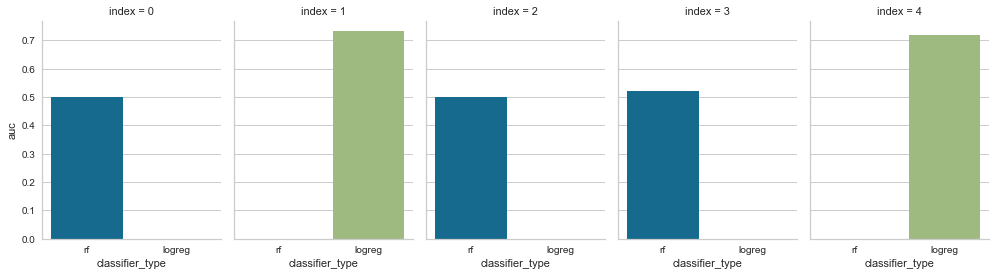

In [186]:
sns.catplot(x="classifier_type", y="auc", col="index",
                data=train_graph, kind="bar",
                height=4, aspect=.7)

In [187]:
FAIRE COURBE

SyntaxError: invalid syntax (490855728.py, line 1)

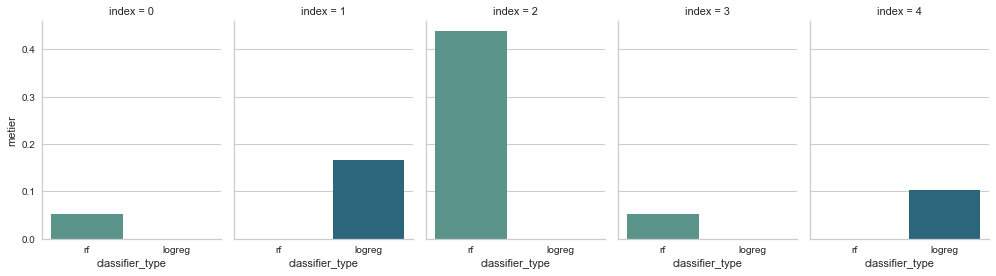

In [188]:
sns.catplot(x="classifier_type", y="metier",
                col="index",orient="v",
                data=train_graph, kind="bar",palette="crest",
                height=4, aspect=.7)

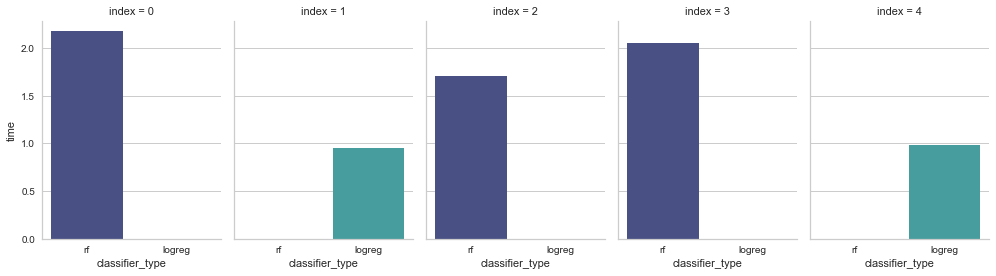

In [189]:
sns.catplot(x="classifier_type", y="time",
                col="index",
                data=train_graph, kind="bar",palette='mako',
                height=4, aspect=.7)

In [199]:
import joblib

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe Roc')
    plt.legend()
    plt.show()


def pipeline_training_metrics(y_prob, y_test):
    # On créé un vecteur de prédiction à partir du vecteur de probabilités
    y_pred = np.where(y_prob > 0.5, 1, 0) 

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print(roc_auc)
    #print("false positive rate : ", false_positive_rate)
    #print("true positive rate : ", true_positive_rate)
    x_rate = false_positive_rate
    y_rate = true_positive_rate 

    # This is the ROC curve
    plot_roc_curve(x_rate,y_rate)
    
    CM = metrics.confusion_matrix(y_test, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    metier = (FN*0.1+FP*0.9)/(FN+FP+TN+TP)
    
    print('FULL Métrique Métier : ', metier)

    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
    #Matrice de confusion
    conf = metrics.confusion_matrix(y_test, y_pred)
    conf
    sns.heatmap(conf, square=True, annot=True, cbar=False)
            #, xticklabels=list(iris.target_names)
            #, yticklabels=list(iris.target_names))
    plt.xlabel('valeurs prédites')
    plt.ylabel('valeurs réelles')
    plt.title('Matrice de confusion %')
    plt.show()
    
    sns.heatmap(conf/np.sum(conf), annot=True, 
            fmt='.2%', cmap='Blues')
    plt.xlabel('valeurs prédites')
    plt.ylabel('valeurs réelles')
    plt.title('Matrice de confusion %')
    plt.show()
    
    print("\nSur le jeu de test auc : {:.3f}".format(metrics.roc_auc_score(y_test, y_pred)))
    print("\nSur le jeu de test f1_score : {:.3f}".format(metrics.f1_score(y_test, y_pred)))
    print("\nSur le jeu de test precision : {:.3f}".format(metrics.precision_score(y_test, y_pred)))
    print("\nSur le jeu de test recall : {:.3f}".format(metrics.recall_score(y_test, y_pred)))
    #

def result_compare_model(df_best_score_history):
    all_bestscore_history=[]
    i=0
    for item in df_best_score_history.itertuples():
        res = compare_best_model(i, item.classifier_type, item.params, X_train, y_train, X_test, y_test)
        all_bestscore_history.append(res)
        i=i+1
    return pd.DataFrame(all_bestscore_history)

def compare_best_model(i,classifier_type, params, X_train, y_train, X_test, y_test):
   ## Correction des paramètres identiques
    if 'max_depthg' in params:
        params["max_depth"]=int(params["max_depthg"])
        params["n_estimators"]=int(params["n_estimatorsg"])
        del params["max_depthg"]
        del params["n_estimatorsg"]
    
    print(params)
    if classifier_type == 'rf':
        clf = RandomForestClassifier(**params)
    elif (classifier_type == 'logreg'):
        clf = LogisticRegression(**params)
    else:
        return 0
    
    t0 = time.time()
             
    clf.fit(X_train, y_train)
    
    y_prob = clf.predict_proba(X_test)[:,1] 
    
    # On créé un vecteur de prédiction à partir du vecteur de probabilités
    y_pred = np.where(y_prob > 0.5, 1, 0) 
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    metier_c=fmetric_metier(y_test, y_pred)
    pipeline_training_metrics(y_pred, y_test)
    time_res=time.time() - t0
    return {'classifier_type':classifier_type, 'score':roc_auc,'metier':metier_c,'time': time_res, 'params':params}

{'max_depth': 7, 'max_features': 1, 'min_samples_leaf': 0.2932615820869342, 'min_samples_split': 3, 'n_estimators': 212}
FULL Métrique Métier :  0.15136268343815515
0.7466153086767973


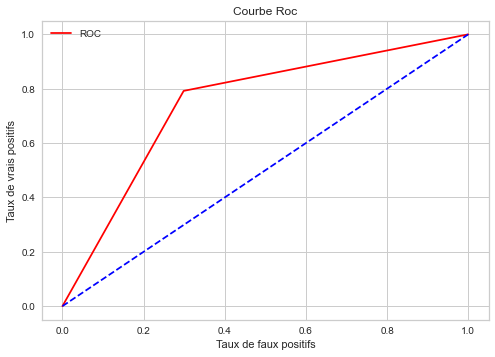

FULL Métrique Métier :  0.15136268343815515
Mean Absolute Error: 0.2557651991614256
Mean Squared Error: 0.2557651991614256
Root Mean Squared Error: 0.5057323394459026


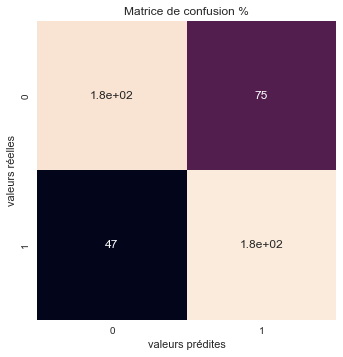

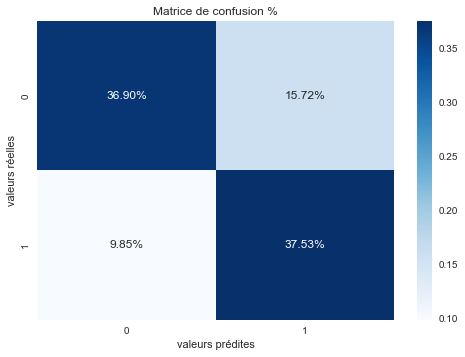


Sur le jeu de test auc : 0.747

Sur le jeu de test f1_score : 0.746

Sur le jeu de test precision : 0.705

Sur le jeu de test recall : 0.792
{'C': 0.5038520158015879, 'penalty': 'l2', 'solver': 'liblinear'}
FULL Métrique Métier :  0.15387840670859537
0.7559055812149633


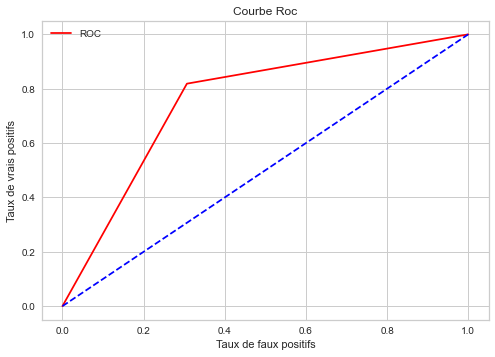

FULL Métrique Métier :  0.15387840670859537
Mean Absolute Error: 0.24737945492662475
Mean Squared Error: 0.24737945492662475
Root Mean Squared Error: 0.4973725514406929


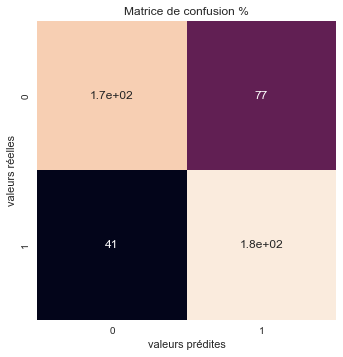

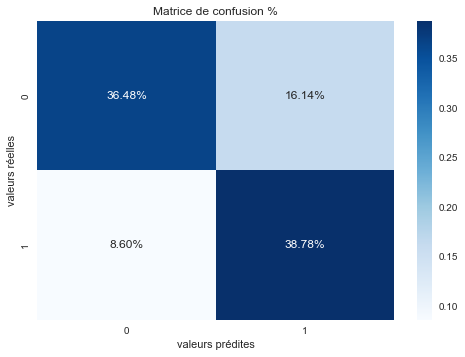


Sur le jeu de test auc : 0.756

Sur le jeu de test f1_score : 0.758

Sur le jeu de test precision : 0.706

Sur le jeu de test recall : 0.819
{'max_depth': 7, 'max_features': 2, 'min_samples_leaf': 0.3722936012377335, 'min_samples_split': 5, 'n_estimators': 186}
FULL Métrique Métier :  0.47358490566037736
0.5


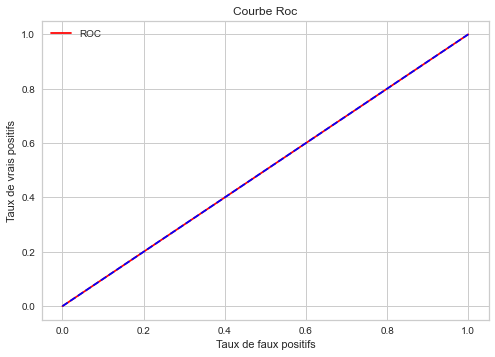

FULL Métrique Métier :  0.47358490566037736
Mean Absolute Error: 0.5262054507337526
Mean Squared Error: 0.5262054507337526
Root Mean Squared Error: 0.7254002003954456


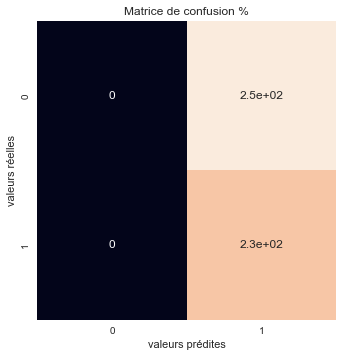

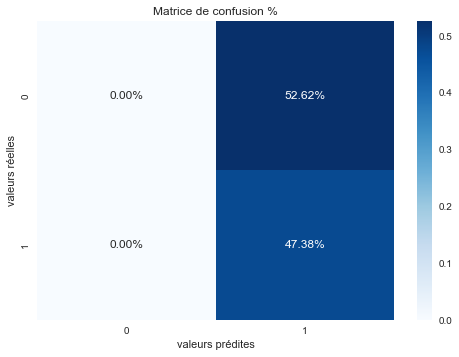


Sur le jeu de test auc : 0.500

Sur le jeu de test f1_score : 0.643

Sur le jeu de test precision : 0.474

Sur le jeu de test recall : 1.000
{'max_depth': 4, 'max_features': 2, 'min_samples_leaf': 0.15719242037767256, 'min_samples_split': 5, 'n_estimators': 238}
FULL Métrique Métier :  0.12976939203354299
0.7594577442442619


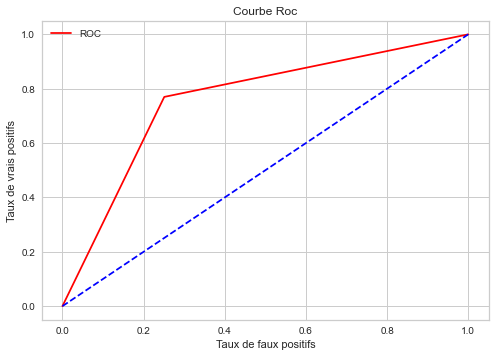

FULL Métrique Métier :  0.12976939203354299
Mean Absolute Error: 0.24109014675052412
Mean Squared Error: 0.24109014675052412
Root Mean Squared Error: 0.49100931432155553


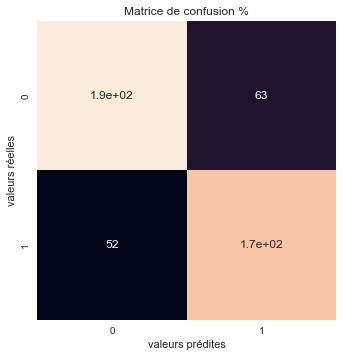

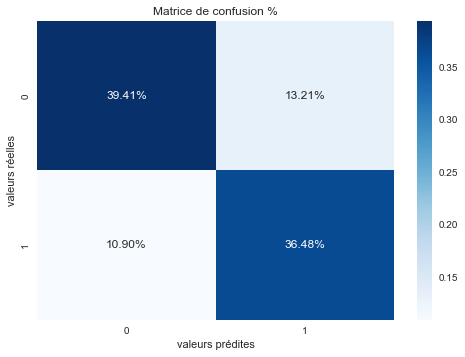


Sur le jeu de test auc : 0.759

Sur le jeu de test f1_score : 0.752

Sur le jeu de test precision : 0.734

Sur le jeu de test recall : 0.770
{'C': 0.1616642529234369, 'penalty': 'l1', 'solver': 'liblinear'}
FULL Métrique Métier :  0.14633123689727462
0.7638737087050032


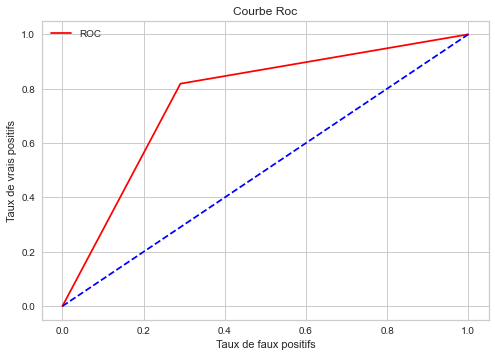

FULL Métrique Métier :  0.14633123689727462
Mean Absolute Error: 0.2389937106918239
Mean Squared Error: 0.2389937106918239
Root Mean Squared Error: 0.4888698300077679


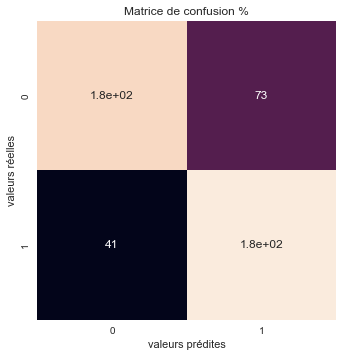

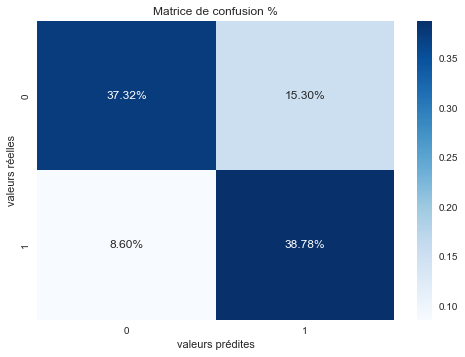


Sur le jeu de test auc : 0.764

Sur le jeu de test f1_score : 0.764

Sur le jeu de test precision : 0.717

Sur le jeu de test recall : 0.819


In [200]:
final_result=result_compare_model(df_metrics_history)

In [201]:
final_result = final_result.reset_index()

In [202]:

data=final_result.copy()



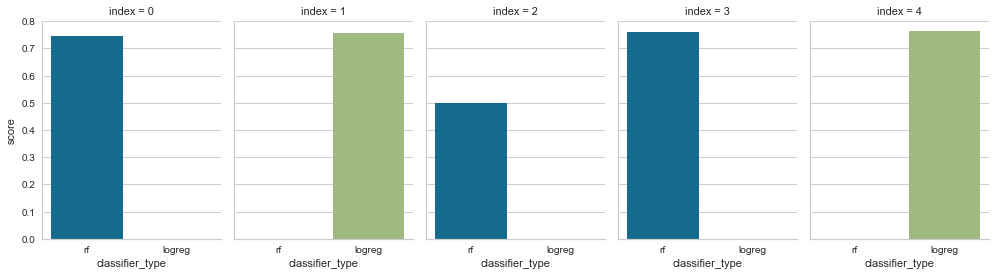

In [203]:
sns.catplot(x="classifier_type", y="score",
                col="index",
                data=data, kind="bar",
                height=4, aspect=.7)

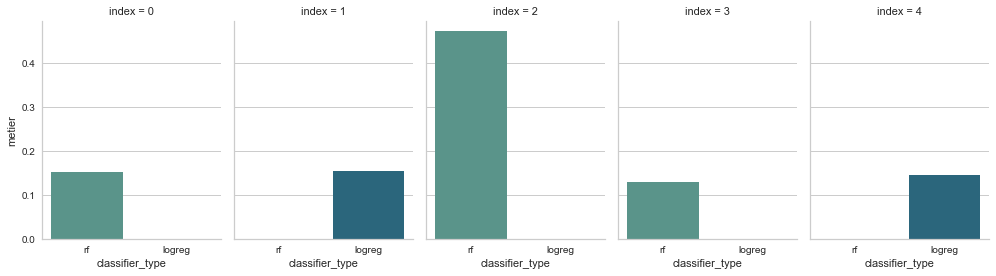

In [204]:
sns.catplot(x="classifier_type", y="metier",
                col="index",
                data=data, kind="bar",palette="crest",
                height=4, aspect=.7)

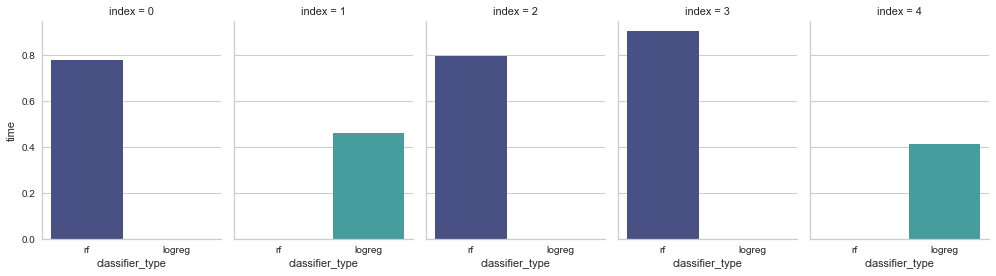

In [205]:
sns.catplot(x="classifier_type", y="time",
                col="index",
                data=data, kind="bar",palette="mako",
                height=4, aspect=.7)

In [206]:
final_result

,index,classifier_type,score,metier,time,params
0,0,rf,0.746615,0.151363,0.776923,"{'max_depth': 7, 'max_features': 1, 'min_sampl..."
1,1,logreg,0.755906,0.153878,0.461767,"{'C': 0.5038520158015879, 'penalty': 'l2', 'so..."
2,2,rf,0.500000,0.473585,0.794874,"{'max_depth': 7, 'max_features': 2, 'min_sampl..."
3,3,rf,0.759458,0.129769,0.903585,"{'max_depth': 4, 'max_features': 2, 'min_sampl..."
4,4,logreg,0.763874,0.146331,0.413893,"{'C': 0.1616642529234369, 'penalty': 'l1', 'so..."


### Choice RandomForest

In [ ]:
##

import joblib
from sklearn.ensemble import RandomForestClassifier
# create RF
rf = RandomForestClassifier()
# fit on some data
rf.fit(X, y)

# save
joblib.dump(rf, "my_random_forest.joblib")

# load
loaded_rf = joblib.load("my_random_forest.joblib")
loaded_rf.predict(X)

## Approche Modèle sur mesure simple : Concepteur / Designer - service Azure Machine Learning